In [1]:
# -*- coding: utf-8 -*-
#-*- coding: cp950 -*-
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from typing import *

import torch
import torch.optim as optim

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *
from fastai.core import *

import tensorflow as tf
import random as rn
np.random.seed(0)
rn.seed(0)

import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
# Importing sklearn libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

from keras.preprocessing import image
from sklearn.model_selection import train_test_split

# Importing Keras libraries
from keras.utils import np_utils
from keras.models import Sequential
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
 
import warnings
warnings.filterwarnings('ignore')
import cv2

Using TensorFlow backend.


In [0]:
os.listdir()

['.config', 'sample_data']

In [2]:
#在colab下接入google drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)
base_dir = '/content/gdrive/My Drive'
#path = Path(base_dir +'/imgs4')  #imgs
path = Path(base_dir +'/DLtry')
path.mkdir(parents=True,exist_ok=True)
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#分割數據與設定參數
input_shape = (224, 224, 3)
batch_size = 128
epochs = 12 #100
num_classes = 2  #######

x = []
y = []

for f in os.listdir("sakura"):
    x.append(image.img_to_array(image.load_img("sakura/"+f, target_size=input_shape[:2])))
    y.append(0)
for f in os.listdir("cosmos"):
    x.append(image.img_to_array(image.load_img("cosmos/"+f, target_size=input_shape[:2])))
    y.append(1)
    
x = np.asarray(x)
x /= 255
y = np.asarray(y)
y = keras.utils.to_categorical(y, num_classes)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state= 3)

In [4]:
#建立DNN模型
from keras.models import Sequential  #必須適時呼叫***
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,optimizer="SGD",metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,verbose=1, validation_data=(x_test, y_test))

Train on 20 samples, validate on 10 samples
Epoch 1/12
20/20 [==============================] - 6s 286ms/step - loss: 0.6993 - accuracy: 0.5500 - val_loss: 1.6414 - val_accuracy: 0.5000
Epoch 2/12
20/20 [==============================] - 4s 222ms/step - loss: 1.9550 - accuracy: 0.5000 - val_loss: 0.7921 - val_accuracy: 0.5000
Epoch 3/12
20/20 [==============================] - 5s 258ms/step - loss: 1.4339 - accuracy: 0.6000 - val_loss: 0.8613 - val_accuracy: 0.5000
Epoch 4/12
20/20 [==============================] - 5s 225ms/step - loss: 0.8930 - accuracy: 0.5000 - val_loss: 1.3963 - val_accuracy: 0.5000
Epoch 5/12
20/20 [==============================] - 4s 220ms/step - loss: 1.3080 - accuracy: 0.5000 - val_loss: 1.0090 - val_accuracy: 0.5000
Epoch 6/12
20/20 [==============================] - 4s 222ms/step - loss: 0.9255 - accuracy: 0.5000 - val_loss: 0.6833 - val_accuracy: 0.5000
Epoch 7/12
20/20 [==============================] - 4s 220ms/step - loss: 0.6375 - accuracy: 0.5000 - va

In [0]:
最終的に訓練データに対する精度が100%、バリデーションデータに対する精度が70%になっています。
それぞれの精度の推移を可視化するとわかるように、過学習の兆候が見られます。
これは訓練データが10枚/クラス × 2クラス = 20枚と、非常に少ないために起こっていることです。

In [0]:
エポック数を5倍の500に増やすと、過学習の傾向がより顕著に観察できます。100エポック目では70%程度あったバリデーションデータに対する精度が、
500エポックが経過するころには60%前後に下がっています。また、訓練データに対する損失関数の値は下がり続けていますが、
バリデーションデータに対する損失関数の値が100エポックくらいを境に逆に上がり始めています。

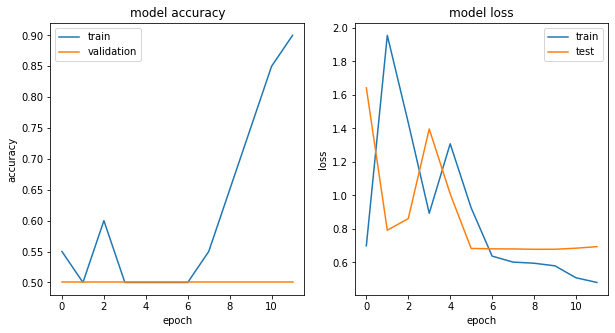

In [6]:
def plot_acc_loss(history):
    fig = plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
 
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
 
plot_acc_loss(history)